In [1]:
from lenskit.metrics import dataGenerator
from lenskit import batch, topn, util, topnFair
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, user_knn as knn
#from lenskit import topn, topnFair

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
import math

In [4]:
#ratings = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/ratings.1.csv', sep=',',
#                      names=['user', 'item', 'rating', 'timestamp'], header=0)

#items = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
#                      names=['movieId','title','genres'], header=0)

ratings = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/ratings.1.csv', sep=',',
                      names=['user', 'item', 'rating', 'timestamp'], header=0)

items = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
                      names=['item','title','genres'], header=0)

#C:\Users\josse\Git-kode projects\Speciale\Fair-Recommendations\ml-latest-small\ratings.csv

In [5]:
#items

In [6]:
items_dummy = pd.concat([items, items['genres'].str.get_dummies(sep='|')], axis=1)
items_dummy.head()

,item,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
algo_ii = knn.UserUser(20)
algo_als = als.BiasedMF(50)

In [8]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [9]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 1, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))
   
    

In [10]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs_joined = all_recs.join(items_dummy.set_index('item'), on='item')
all_recs_joined.head()

,item,score,user,rank,Algorithm,title,genres,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1961,3.256902,1,1,ItemItem,Rain Man (1988),Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2085,3.256902,1,2,ItemItem,101 Dalmatians (One Hundred and One Dalmatians...,Adventure|Animation|Children,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1198,3.256902,1,3,ItemItem,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1197,3.256902,1,4,ItemItem,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,0,1,1,...,0,0,0,0,0,1,0,0,0,0
4,2018,3.256902,1,5,ItemItem,Bambi (1942),Animation|Children|Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test_data = pd.concat(test_data, ignore_index=True)
test_data.head()

,user,item,rating
0,1,2150,3.0
1,1,3671,3.0
2,1,2968,1.0
3,1,1287,2.0
4,2,357,3.0


In [12]:
_protected_group2 = all_recs_joined.loc[all_recs_joined['Action'] == 1]
_protected_group2.head()
_protected_group2['item'].values

array([ 1198,  1197,  1196,  1127,  2115,  1036,  1200,  1291,  1240,
        1220,  1208,  1387,  1396,  1858,  1210,  3265,   589,   541,
         480,   260,   112,  2194,  2406,  2723,  2628,  2640,  2716,
         442,  2959,  1197,  2723,  2716,  1396,  1858,  1953,  1387,
        1291,  2640,  2628,  2115,  2194,  2406,  1198,  1127,  1036,
        1208,   541,   260,   112,  1200,  1196,  1240,  3265,  1220,
         592,   589,  1858,  1953,  1396,  1387,  1196,  1240,  1220,
        1198,  3265,  1036,  1291,  1127,  1200,  2716,  2723,   260,
         112,  2628,  2640,  2115,   541,  2194,  1208,  2406,   592,
        2959,   110,  2028, 44191,   736,  1580,   165,   292,   168,
         367,   208,   485,  5349, 58559,  8636,  1129,  2193,   377,
         405,   474,   592,   589,   153,   480,    10,   367,   165,
         168,   185,   208,   292,   485,   474,   405,  1197,  2959,
         589,  1127,  2716,  2723,  1196,  2115,  1036,  2406,  2194,
        2628,  2640,

In [13]:
recs_temp = all_recs_joined.iloc[100:110,:]
recs_temp 


,item,score,user,rank,Algorithm,title,genres,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
100,2959,4.935426,2,1,ItemItem,Fight Club (1999),Action|Crime|Drama|Thriller,0,1,0,...,0,0,0,0,0,0,0,1,0,0
101,3949,4.935426,2,2,ItemItem,Requiem for a Dream (2000),Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,318,4.935426,2,3,ItemItem,"Shawshank Redemption, The (1994)",Crime|Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,1197,4.824550,2,4,ItemItem,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,0,1,1,...,0,0,0,0,0,1,0,0,0,0
104,597,4.694877,2,5,ItemItem,Pretty Woman (1990),Comedy|Romance,0,0,0,...,0,0,0,0,0,1,0,0,0,0
105,33166,4.694877,2,6,ItemItem,Crash (2004),Crime|Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,1035,4.694877,2,7,ItemItem,"Sound of Music, The (1965)",Musical|Romance,0,0,0,...,0,0,0,1,0,1,0,0,0,0
107,2081,4.442241,2,8,ItemItem,"Little Mermaid, The (1989)",Animation|Children|Comedy|Musical|Romance,0,0,0,...,0,0,0,1,0,1,0,0,0,0
108,50068,4.435426,2,9,ItemItem,Letters from Iwo Jima (2006),Drama|War,0,0,0,...,0,0,0,0,0,0,0,0,1,0
109,48783,4.435426,2,10,ItemItem,Flags of Our Fathers (2006),Drama|War,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [14]:
def calculate_demParity(recs, protected_group): 
    #beslut hvad der er nemmest. Skal denne tage "protected group". contains eller tage en protected variabel?
    
    exposure_pro = 0; 
    exposure_unpro = 0;
    print(_protected_group2['item'].values)

    for index, row in recs.iterrows():
        if row["item"] in _protected_group2['item'].values:
            print(row["item"], "in protected group")
            exposure_pro = exposure_pro + (1/math.log2(1+row["rank"])) 
        else:
            exposure_unpro = exposure_unpro + (1/math.log2(1+row["rank"]))  
   
    return abs(exposure_pro-exposure_unpro)

In [15]:
x = calculate_demParity(recs_temp, _protected_group2)
x 

[ 1198  1197  1196  1127  2115  1036  1200  1291  1240  1220  1208  1387
  1396  1858  1210  3265   589   541   480   260   112  2194  2406  2723
  2628  2640  2716   442  2959  1197  2723  2716  1396  1858  1953  1387
  1291  2640  2628  2115  2194  2406  1198  1127  1036  1208   541   260
   112  1200  1196  1240  3265  1220   592   589  1858  1953  1396  1387
  1196  1240  1220  1198  3265  1036  1291  1127  1200  2716  2723   260
   112  2628  2640  2115   541  2194  1208  2406   592  2959   110  2028
 44191   736  1580   165   292   168   367   208   485  5349 58559  8636
  1129  2193   377   405   474   592   589   153   480    10   367   165
   168   185   208   292   485   474   405  1197  2959   589  1127  2716
  2723  1196  2115  1036  2406  2194  2628  2640  1291  1198  1240  1396
   260  1387   112  1858   541  1200  1208  1220  3265  1197  2959  1953
  1240  1220  2406  1291  2628  2640  1387  2194  2716  2723  1396  2115
  1200   541  1858   260   112  1036  1208  1198  3

1.6822062219415599

In [16]:
# user , algorithms = iput to group_cols --> de koloner der skal  groupes på 
# res: categories of protected variable 
res= list(all_recs_joined.iloc[:,8:])
print(res)

rla = topnFair.FairRecListAnalysis(['user', "Algorithm"])
rla.add_metric("rND")
rla.add_metric("rKL")
rla.add_metric("rRD")
rla.add_metric("div")
rla.add_metric("dem_parity")
results = rla.compute(all_recs_joined, test_data, "Action", res)
results.head()

['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
ti_cols:  ['user', 'item']
res.index:  MultiIndex(levels=[[1, 2, 3, 4, 5], ['ALS', 'ItemItem']],
           labels=[[0, 0, 1, 1, 2, 2, 3, 3, 4, 4], [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]],
           names=['user', 'Algorithm'])
                rND  rKL  rRD  div  dem_parity
user Algorithm                                
1    ALS        NaN  NaN  NaN  NaN         NaN
     ItemItem   NaN  NaN  NaN  NaN         NaN
2    ALS        NaN  NaN  NaN  NaN         NaN
     ItemItem   NaN  NaN  NaN  NaN         NaN
3    ALS        NaN  NaN  NaN  NaN         NaN


rND       rKL       rRD       div  dem_parity
user Algorithm                                                    
1    ALS        0.100908  0.017105  0.175111  0.842105    0.333117
     ItemItem   0.114733  0.027142  0.096902  0.842105    0.382994
2    ALS        0.092560  0.020280  0.148599  0.842105    0.391284
     ItemItem   0.089621  0.024157  0.164854  0.842105    0.377504
3    ALS        0.058245  0.008546  0.113725  0.947368    0.367556

In [17]:
results.groupby('Algorithm').rND.mean()

Algorithm
ALS         0.079008
ItemItem    0.132211
Name: rND, dtype: float64

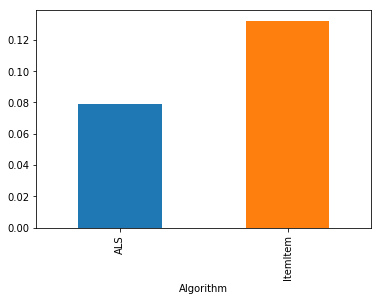

In [18]:
results.groupby('Algorithm').rND.mean().plot.bar()


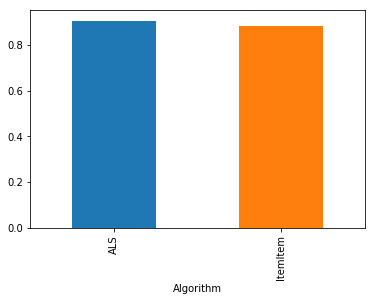

In [19]:
results.groupby('Algorithm').div.mean().plot.bar()